<a href="https://colab.research.google.com/github/SneyderGF/BigData-Spark-Beer/blob/main/Beer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 3.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.1-py2.py3-none-any.whl size=311285398 sha256=a628b40406b82de4cbdf94b6ea3357fa49bdad902110799a24b5da6a0aa853d2
  Stored in directory: /root/.cache/pip/wheels/0d/77/a3/ff2f74cc9ab41f8f594dabf0579c2a7c6de920d584206e0834
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *


In [ ]:
# Crear una instancia de SparkSession
spark = SparkSession.builder.appName("BeerReviewsAnalysis").getOrCreate()

In [ ]:
import zipfile

# Ruta del archivo ZIP o TAR
archivo_comprimido = "/content/beer_reviews.parquet.zip"  # Actualiza con tu ruta de archivo

# Ruta de destino para la carpeta descomprimida
ruta_destino = "/content/beer_reviews.parquet"  # Puedes modificar la ruta según tus necesidades

# Descomprimir el archivo
with zipfile.ZipFile(archivo_comprimido, 'r') as zip_ref:
    zip_ref.extractall(ruta_destino)



PARA NO INGRESAR MANUALMENTE EL ESQUEMA

In [ ]:

# Cargar los datos del parquet
df = spark.read.parquet("/content/beer_reviews.parquet/beer_reviews.parquet", inferSchema=True, header=True)
# Mostrar el esquema de los datos
df.printSchema()
# Mostrar el DataFrame
df.show()

root
 |-- index: integer (nullable = true)
 |-- brewery_id: integer (nullable = true)
 |-- brewery_name: string (nullable = true)
 |-- review_time: integer (nullable = true)
 |-- review_overall: double (nullable = true)
 |-- review_aroma: double (nullable = true)
 |-- review_appearance: double (nullable = true)
 |-- review_profilename: string (nullable = true)
 |-- beer_style: string (nullable = true)
 |-- review_palate: double (nullable = true)
 |-- review_taste: double (nullable = true)
 |-- beer_name: string (nullable = true)
 |-- beer_abv: double (nullable = true)
 |-- beer_beerid: integer (nullable = true)

+-----+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------------+-------------+------------+--------------------+--------+-----------+
|index|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|          beer_style|review_palate|review_taste|         

In [ ]:
# Especificar manualmente el esquema del DataFrame
#schema = StructType([
    #StructField("review_time", LongType(), nullable=True),
    #StructField("review_overall", DoubleType(), nullable=True),
    #StructField("beer_name", StringType(), nullable=True),
    #StructField("beer_style", StringType(), nullable=True),
    #StructField("review_palate", DoubleType(), nullable=True),
    #StructField("review_taste", DoubleType(), nullable=True),
    #StructField("beer_abv", DoubleType(), nullable=True),
    #StructField("review_appearance", DoubleType(), nullable=True),
    #StructField("review_profilename", StringType(), nullable=True),
    #StructField("brewery_name", StringType(), nullable=True),
#])

# Cargar el DataFrame desde el archivo Parquet
#df = spark.read.parquet("/content/beer_reviews.parquet/beer_reviews.parquet")

# Mostrar el DataFrame
#df.show()


#BORRAR REGISTROS DUPLICADOS, ULTIMAS RESEÑAS

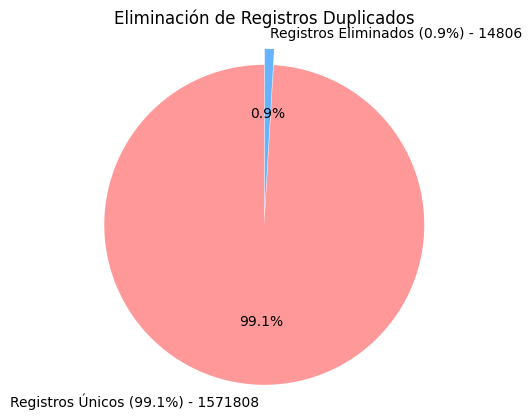

In [ ]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Eliminar registros duplicados y quedarse con la última reseña de cada usuario
df_resenias_unicas = df.orderBy(col('review_time').desc()).dropDuplicates(['beer_beerid', 'review_profilename'])

# Contar la cantidad total de registros y la cantidad de registros eliminados
total_registros = df.count()
registros_eliminados = total_registros - df_resenias_unicas.count()

# Obtener los porcentajes de registros únicos y registros eliminados
porcentaje_registros_unicos = (df_resenias_unicas.count() / total_registros) * 100
porcentaje_registros_eliminados = 100 - porcentaje_registros_unicos

# Graficar el resultado en un gráfico de torta
labels = ['Registros Únicos ({:.1f}%) - {}'.format(porcentaje_registros_unicos, df_resenias_unicas.count()),
          'Registros Eliminados ({:.1f}%) - {}'.format(porcentaje_registros_eliminados, registros_eliminados)]
sizes = [df_resenias_unicas.count(), registros_eliminados]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Eliminación de Registros Duplicados')
plt.show()



In [ ]:
df_u = df_resenias_unicas
df_u.show()

+------+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------+-------------+------------+--------------------+--------+-----------+
| index|brewery_id|        brewery_name|review_time|review_overall|review_aroma|review_appearance|review_profilename|    beer_style|review_palate|review_taste|           beer_name|beer_abv|beer_beerid|
+------+----------+--------------------+-----------+--------------+------------+-----------------+------------------+--------------+-------------+------------+--------------------+--------+-----------+
| 45494|         2|Yellow Rose Brewi...| 1066876922|           4.5|         4.0|              4.0|       NeroFiddled|American Stout|          4.0|         4.0|Wildcatter's Crud...|    null|          4|
| 45495|         2|Yellow Rose Brewi...| 1054498901|           3.0|         4.0|              4.0|     assurbanipaul|American Stout|          2.5|         3.5|Wildcatter's Crud...|    null|   

In [ ]:
df_u.describe().show()


+-------+-----------------+-----------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+----------+------------------+-----------------+------------------------+------------------+------------------+
|summary|            index|       brewery_id|        brewery_name|         review_time|    review_overall|      review_aroma| review_appearance|  review_profilename|beer_style|     review_palate|     review_taste|               beer_name|          beer_abv|       beer_beerid|
+-------+-----------------+-----------------+--------------------+--------------------+------------------+------------------+------------------+--------------------+----------+------------------+-----------------+------------------------+------------------+------------------+
|  count|          1571808|          1571808|             1571793|             1571808|           1571808|           1571808|           1571808|             1571480|   1

#1 ANALISIS SPARK SQL

In [ ]:
from pyspark.sql.functions import corr

# Calcular la matriz de correlación utilizando Spark SQL
correlation_matrix = df_u.selectExpr("corr(review_overall, review_aroma) as correlation_aroma",
                                    "corr(review_overall, review_appearance) as correlation_appearance",
                                    "corr(review_overall, review_palate) as correlation_palate",
                                    "corr(review_overall, review_taste) as correlation_taste",
                                    "corr(review_overall, beer_abv) as correlation_abv"
                                    ).collect()[0]

# Mostrar las correlaciones
for column, correlation in correlation_matrix.asDict().items():
    print(f"Correlation with review_overall for {column}: {correlation}")


Correlation with review_overall for correlation_aroma: 0.6160038490935447
Correlation with review_overall for correlation_appearance: 0.5014394177026078
Correlation with review_overall for correlation_palate: 0.7018341392626009
Correlation with review_overall for correlation_taste: 0.7900270540228237
Correlation with review_overall for correlation_abv: 0.1383985589198


#2 ANALISIS SPARK SQL

+--------------+------+
|review_overall| count|
+--------------+------+
|           0.0|     7|
|           1.0| 10891|
|           1.5| 12885|
|           2.0| 37998|
|           2.5| 58140|
|           3.0|164571|
|           3.5|299641|
|           4.0|577375|
|           4.5|320462|
|           5.0| 89838|
+--------------+------+



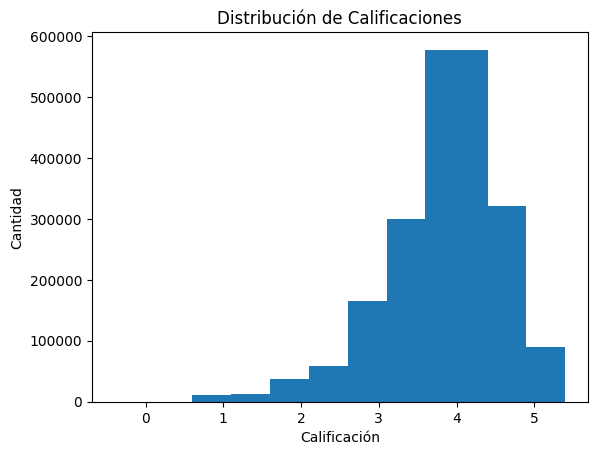

+--------------------+------+
|          beer_style| count|
+--------------------+------+
|        American IPA|115699|
|American Double /...| 84686|
|American Pale Ale...| 62776|
|Russian Imperial ...| 53555|
|American Double /...| 50151|
|     American Porter| 50112|
|American Amber / ...| 45295|
|Belgian Strong Da...| 37514|
|Fruit / Vegetable...| 33701|
| American Strong Ale| 31620|
+--------------------+------+



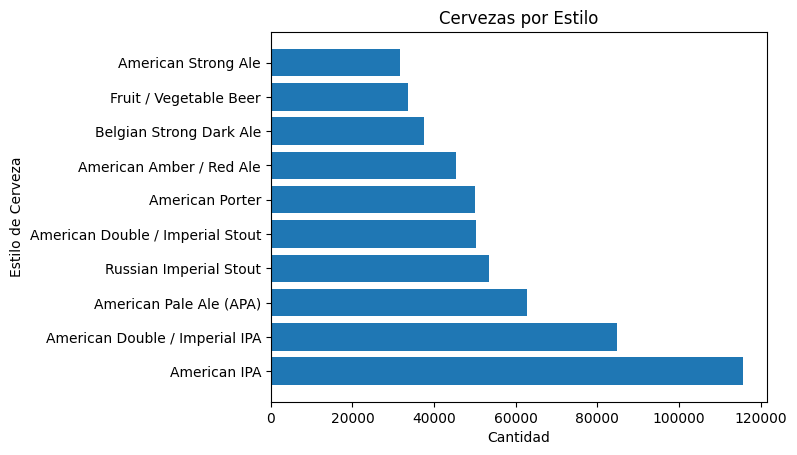

In [ ]:
# Distribución de calificaciones (review_overall)
df_u.createOrReplaceTempView("beer_reviews")
rating_distribution = spark.sql("SELECT review_overall, COUNT(*) AS count FROM beer_reviews GROUP BY review_overall ORDER BY review_overall")
rating_distribution.show()

# Gráfico de histograma de calificaciones
import matplotlib.pyplot as plt
import pandas as pd

rating_distribution_pd = rating_distribution.toPandas()
plt.bar(rating_distribution_pd['review_overall'], rating_distribution_pd['count'])
plt.xlabel('Calificación')
plt.ylabel('Cantidad')
plt.title('Distribución de Calificaciones')
plt.show()

# Cantidad de cervezas por estilo (beer_style)
beer_style_count = spark.sql("SELECT beer_style, COUNT(*) AS count FROM beer_reviews GROUP BY beer_style ORDER BY count DESC LIMIT 10")
beer_style_count.show()

# Gráfico de barras de estilos de cerveza más comunes
beer_style_count_pd = beer_style_count.toPandas()
plt.barh(beer_style_count_pd['beer_style'], beer_style_count_pd['count'])
plt.xlabel('Cantidad')
plt.ylabel('Estilo de Cerveza')
plt.title('Cervezas por Estilo')
plt.show()


#3 ANALISIS SPARK SQL

+---------+------------------+
|abv_range|        avg_rating|
+---------+------------------+
|     null|3.6282288917227676|
|      0.0|               2.2|
|      0.1|2.3620689655172415|
|      0.3|2.7962962962962963|
|      0.4| 2.310810810810811|
|      0.5| 2.602286401925391|
|      0.7|2.8333333333333335|
|      0.8|               3.5|
|      0.9|2.8333333333333335|
|      1.0|2.5833333333333335|
|      1.2|2.6333333333333333|
|      1.3|               3.5|
|      1.4|               4.0|
|      1.5|2.1666666666666665|
|      1.7|              3.75|
|      1.8|3.7058823529411766|
|      1.9| 4.166666666666667|
|      2.0|3.3129032258064517|
|      2.1|2.6666666666666665|
|      2.2|2.5689655172413794|
+---------+------------------+
only showing top 20 rows



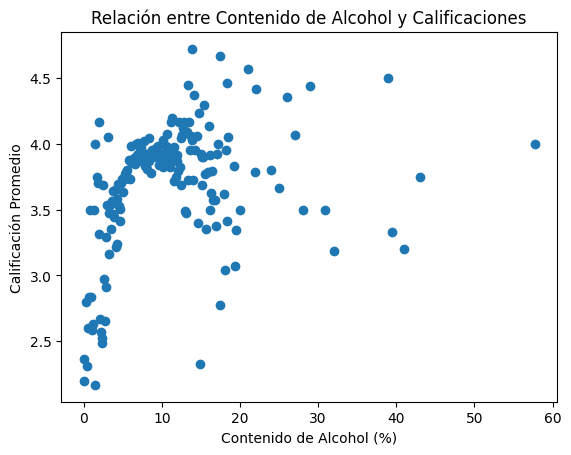

In [ ]:
# Promedio de calificaciones por rango de contenido de alcohol (beer_abv)
df_u.createOrReplaceTempView("beer_reviews")
avg_rating_by_abv = spark.sql("SELECT ROUND(beer_abv, 1) AS abv_range, AVG(review_overall) AS avg_rating FROM beer_reviews GROUP BY abv_range ORDER BY abv_range")
avg_rating_by_abv.show()

# Gráfico de dispersión de calificaciones por contenido de alcohol
avg_rating_by_abv_pd = avg_rating_by_abv.toPandas()
plt.scatter(avg_rating_by_abv_pd['abv_range'], avg_rating_by_abv_pd['avg_rating'])
plt.xlabel('Contenido de Alcohol (%)')
plt.ylabel('Calificación Promedio')
plt.title('Relación entre Contenido de Alcohol y Calificaciones')
plt.show()
